In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from MLib.Core.losses import MMD_tf
from MLib.Core.kernels import gaussian_kernel
from functools import partial
import tensorflow as tf
from MLib.DomainAdaptation.DA import find_optimal_rotation_simple
from scipy.stats import ortho_group

2022-01-13 23:01:46.878769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-13 23:01:46.878850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Define the mean and covariance matrices for different classes


In [2]:
mu_1 = np.array([1,1])
mu_2 = np.array([5,-5])

cov_1 = np.array([
    [2, 0.7],
    [0.7, 1]
])

cov_2 = np.array([
    [2, 1],
    [1, 4]
])

### Create sample from each of the Gaussians

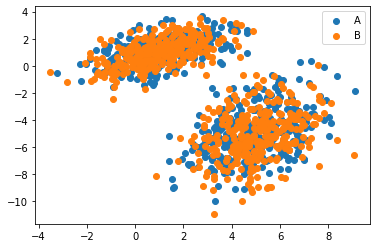

In [3]:
num_samples = 300
samples_c1_a = multivariate_normal.rvs(mu_1, cov_1, num_samples)
samples_c2_a = multivariate_normal.rvs(mu_2, cov_2, num_samples)

samples_c1_b = multivariate_normal.rvs(mu_1, cov_1, num_samples)
samples_c2_b = multivariate_normal.rvs(mu_2, cov_2, num_samples)

samples_a = np.vstack([samples_c1_a, samples_c2_a])
samples_b = np.vstack([samples_c1_b, samples_c2_b])

plt.figure()
plt.scatter(samples_a[:,0], samples_a[:,1])
plt.scatter(samples_b[:,0], samples_b[:,1])
plt.legend(['A', 'B'])
plt.show()

### Create the transformation matrices per each 'domain'

In [4]:
np.random.seed(13)
new_dim = 5
W_a = np.round(np.random.rand(new_dim,len(mu_1))*10,2)
W_b = np.round(np.random.rand(new_dim,len(mu_2))*10,2)

mu_a_orig = np.round(np.random.rand(new_dim)*10,2)
mu_b_orig = np.round(np.random.rand(new_dim)*10,2)

batch_a = np.matmul(samples_a, W_a.T) + mu_a_orig
batch_b = np.matmul(samples_b, W_b.T) + mu_b_orig

### Visualize some axis of the transformed data. The data is now 5-dimensional

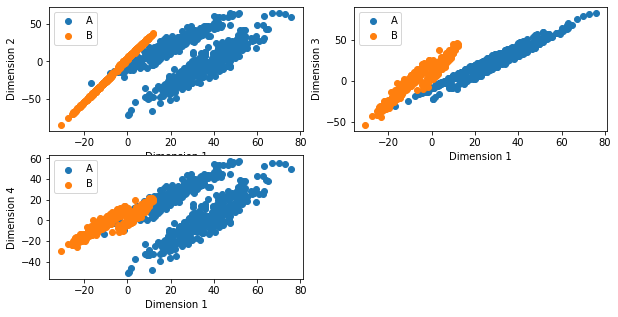

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.scatter(batch_a[:,0], batch_a[:,1])
plt.scatter(batch_b[:,0], batch_b[:,1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(['A', 'B'])

plt.subplot(2,2,2)
plt.scatter(batch_a[:,0], batch_a[:,2])
plt.scatter(batch_b[:,0], batch_b[:,2])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.legend(['A', 'B'])

plt.subplot(2,2,3)
plt.scatter(batch_a[:,0], batch_a[:,3])
plt.scatter(batch_b[:,0], batch_b[:,3])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 4')
plt.legend(['A', 'B'])
plt.show()

### Estimate the empirical moments of the observed data

In [6]:
mu_a = np.mean(batch_a, axis=0)
cov_a = np.cov(batch_a.T)

mu_b = np.mean(batch_b, axis=0)
cov_b = np.cov(batch_b.T)

### Use the eigenvalue decomposition of the empirical covariance matrix to estimate the weights

In [7]:
U_a, S_a, V_a = np.linalg.svd(cov_a)
U_b, S_b, V_b = np.linalg.svd(cov_b)

S_sqrt_a = np.diag(np.sqrt(S_a))
S_sqrt_b = np.diag(np.sqrt(S_b))

num_eigen = np.sum(S_a > 0.00001)
print('Number of positive eigenvalues: ', num_eigen)

W_hat_a = np.matmul(U_a, S_sqrt_a)[:,0:num_eigen]
W_hat_b = np.matmul(U_b, S_sqrt_b)[:,0:num_eigen]

Number of positive eigenvalues:  2


### Project back the data before correcting for the rotation

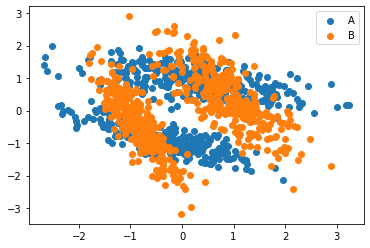

In [8]:
inv_cov_a = np.linalg.inv(np.matmul(W_hat_a.T, W_hat_a))
mult_term_a = np.matmul(inv_cov_a, W_hat_a.T)
z_a = np.matmul(batch_a - mu_a, mult_term_a.T)

inv_cov_b = np.linalg.inv(np.matmul(W_hat_b.T, W_hat_b))
mult_term_b = np.matmul(inv_cov_b, W_hat_b.T)
z_b = np.matmul(batch_b - mu_b, mult_term_b.T)

plt.figure()
plt.scatter(z_a[:,0], z_a[:,1])
plt.scatter(z_b[:,0], z_b[:,1])
plt.legend(['A', 'B'])
plt.show()

### See the result of performing the alignment with different starting points

2022-01-13 23:01:54.975220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-13 23:01:54.975281: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-13 23:01:54.975304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batch-effects): /proc/driver/nvidia/version does not exist
2022-01-13 23:01:54.975698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initial MMD
tf.Tensor(0.0004856817380731737, shape=(), dtype=float64)


Small change in MMD. Stopping.


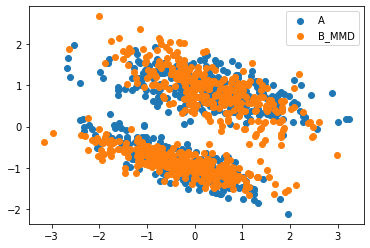

Initial MMD
tf.Tensor(0.0008350109535290029, shape=(), dtype=float64)


Small change in MMD. Stopping.


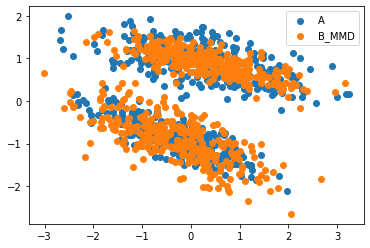

Initial MMD
tf.Tensor(0.000106475431703279, shape=(), dtype=float64)


Small change in MMD. Stopping.


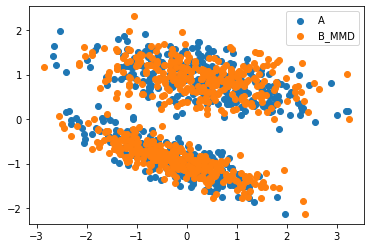

Initial MMD
tf.Tensor(0.000707885252367646, shape=(), dtype=float64)


Small change in MMD. Stopping.


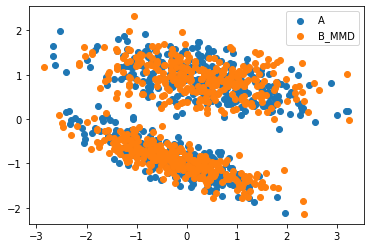

Initial MMD
tf.Tensor(0.0010915068339816258, shape=(), dtype=float64)


Small change in MMD. Stopping.


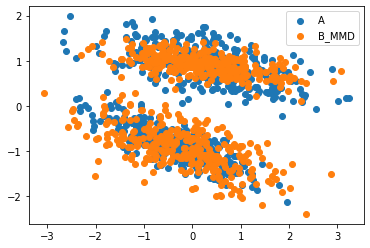

Initial MMD
tf.Tensor(0.0005917714462069235, shape=(), dtype=float64)


Small change in MMD. Stopping.


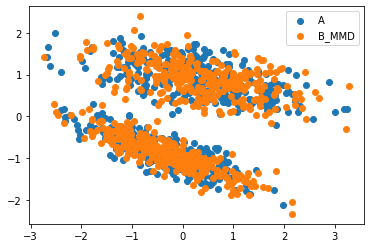

Initial MMD
tf.Tensor(0.0007315582700138101, shape=(), dtype=float64)


Small change in MMD. Stopping.


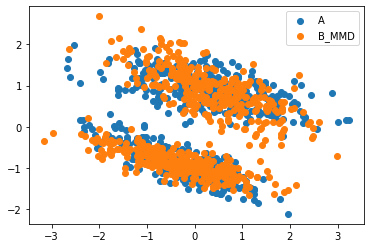

Initial MMD
tf.Tensor(0.0021912893849874715, shape=(), dtype=float64)


Small change in MMD. Stopping.


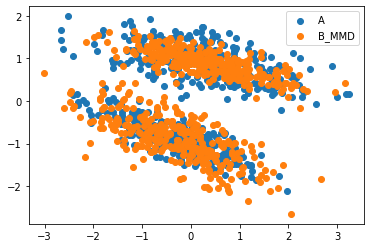

In [9]:
for i in range(8):
    m = ortho_group.rvs(dim=2).T
    c_R, c_MMD = find_optimal_rotation_simple(z_a, z_b, 2, m, 20, max_iter=1000, max_iter_learning_rate=100)

    optimally_rotated_b = np.matmul(z_b, c_R.numpy().T)
    plt.figure()
    plt.scatter(z_a[:,0], z_a[:,1])
    plt.scatter(optimally_rotated_b[:,0], optimally_rotated_b[:,1])
    plt.scatter
    plt.legend(['A', 'B_MMD'])
    plt.show()

### Check the MMD of the possible rotation matrices

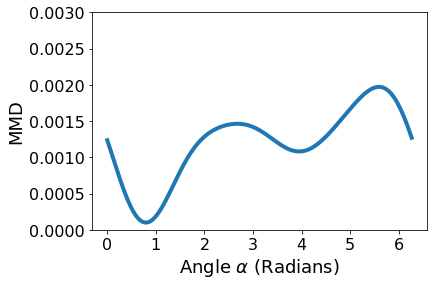

In [10]:
thetas = np.arange(0, 2*np.pi, np.pi/180)
MMD_list_rotations = list()
sigma = 2

for i, theta in enumerate(thetas):
    print('Iteration ' + str(i), end='\r')
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    X_tensor = tf.convert_to_tensor(z_a)
    Y_tensor = tf.convert_to_tensor(z_b)
    c_R = tf.convert_to_tensor(rotation_matrix)

    # Start by computing the current MMD between the two samples
    c_MMD = MMD_tf(X_tensor, tf.linalg.matmul(Y_tensor, tf.transpose(c_R)), sigma)
    MMD_list_rotations.append(c_MMD.numpy())
    
plt.figure()
plt.plot(thetas, MMD_list_rotations, linewidth=4)
plt.xlabel('Angle ' + r'$\alpha$' + ' (Radians)', fontsize=18)
plt.ylabel('MMD', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,.003)
plt.show()

### Repeat, but now for reflection matrices

Reflection


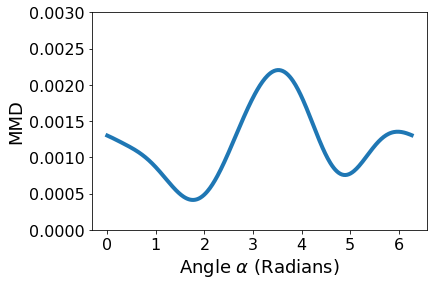

In [11]:
print('Reflection')
thetas = np.arange(0, 2*np.pi, np.pi/180)
MMD_list_reflection = list()
sigma = 2

for i, theta in enumerate(thetas):
    print('Iteration ' + str(i), end='\r')
    rotation_matrix = np.array([
        [np.cos(theta), np.sin(theta)],
        [np.sin(theta), -np.cos(theta)]
    ])

    X_tensor = tf.convert_to_tensor(z_a)
    Y_tensor = tf.convert_to_tensor(z_b)
    c_R = tf.convert_to_tensor(rotation_matrix)

    # Start by computing the current MMD between the two samples
    c_MMD = MMD_tf(X_tensor, tf.linalg.matmul(Y_tensor, tf.transpose(c_R)), sigma)
    MMD_list_reflection.append(c_MMD.numpy())

plt.figure()
plt.plot(thetas, MMD_list_reflection, linewidth=4)
plt.xlabel('Angle ' + r'$\alpha$' + ' (Radians)', fontsize=18)
plt.ylabel('MMD', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,.003)
plt.show()